In [1]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance

def save_geometry(dataframe,geometry,out_path,fname='dataframe.geojson'):
    df_to_save = gpd.GeoDataFrame(geometry=dataframe[geometry],crs="EPSG:4326")
    df_to_save = df_to_save.to_crs("epsg:4326")
    df_to_save.to_file(os.path.join(out_path,fname),driver="GeoJSON")

/home/tandon/anaconda3/envs/pygeo/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Santa Clara California 

In [18]:
data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "California"
city = "SantaClara"
apt_data_path = os.path.join(data_path,state,"APT_2022_06_009_nam_usa_uca.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_06085/Parcels_06085.shp")
building_geojson = os.path.join(data_path,state,'California.geojson')

## Read APT data From MNR Database 

In [ ]:
apt_df = gpd.read_file(apt_data_path)
apt_df = gpd.GeoDataFrame(apt_df,crs="EPSG:4326",geometry='geometry')
apt_df = apt_df.to_crs("epsg:4326")
print("Total number of data points collected from MNR database ",apt_df.shape[0])
gc.collect()
apt_df.head()

# sns.countplot(apt_df['AnchorPoin'])
# print(apt_df['AnchorPoin'].value_counts())

# print("Building Address Points :{}".format(apt_df['AnchorPoin'].value_counts()[0] /apt_df['AnchorPoin'].count()))
# print("Address Parcel  Centroid Points:{}".format(apt_df['AnchorPoin'].value_counts()[1] /apt_df['AnchorPoin'].count() ))

## Read State Building Footprint Data

In [ ]:
# Read MIcrosoft data 
print("reading :",os.path.basename(building_geojson))
footprint_df = gpd.read_file(building_geojson)
footprint_df = gpd.GeoDataFrame(footprint_df, crs="EPSG:4326", geometry='geometry')
print("Building CRS:",footprint_df.crs)

gc.collect()
footprint_df.head()

## Read Parcel Data specific to County

In [ ]:
# read Parcel data
parcel_df = gpd.read_file(parcel_path)
parcel_df = gpd.GeoDataFrame(parcel_df,crs="EPSG:4326",geometry='geometry')
# convert parcel crs to same as building fooprint
parcel_df = parcel_df.to_crs("epsg:4326")
parcel_polygon_changedcrs_df = gpd.GeoDataFrame(geometry=parcel_df['geometry'])

print("CRS after conversion: ",parcel_df.crs)
print("Parcel Data Points :",parcel_df.shape[0])
# parcel_polygon_changedcrs_df.to_file(os.path.join(out_path,"parcel_DistrictofColumbia.geojson"), driver="GeoJSON")
gc.collect()

parcel_df.head(10)

## Process Data 

In [19]:
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,building_shapefile=building_geojson,apt_shape_file=apt_data_path)
processed_df = apt_preprocess.process_dataframe(bfp_count_per_parcel=1)
processed_df.head(10)

2022-08-03 15:21:42,478:INFO:- Creating Realignment-matrix for APT's
2022-08-03 15:21:42,479:INFO:- Processing Land Parcel data and Building Footprints 
2022-08-03 15:37:00,878:INFO:- Processing Anchor-Points data over Parcel-Building Geo-Dataframe


In [ ]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

processed_df['APT_to_Centroid_distance'] = processed_df.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)

processed_df['APT_lat'] = processed_df['APT'].apply(lambda z: z.y)
processed_df['APT_lon'] = processed_df['APT'].apply(lambda z: z.x)

processed_df['updated_lat'] = processed_df['updated_geometries'].apply(lambda z: z.y)
processed_df['updated_lon'] = processed_df['updated_geometries'].apply(lambda z: z.x)
processed_df.head()

In [ ]:
# out_path = os.path.join(data_path,city)
# save_geometry(processed_df,geometry='updated_geometries',out_path=out_path,fname='APT_usa_uca_updated_gemotries.geojson')
# save_geometry(processed_df,geometry='APT',out_path=out_path,fname='APT_usa_uca.geojson')
# save_geometry(processed_df,geometry='building_geometry',out_path=out_path,fname='building_roi_usa_ua.geojson')

In [ ]:
distance_greater_than_50m = processed_df.loc[processed_df['APT_to_Centroid_distance']>50].shape[0]
max_dist = processed_df['APT_to_Centroid_distance'].loc[processed_df['APT_to_Centroid_distance']>50].max()
print("Max distance APT from Parcel to Building Centroid {:.2f} m".format(processed_df['APT_to_Centroid_distance'].loc[processed_df['APT_to_Centroid_distance']>50].max()))
print("Data points greater than 50m: {:.2f}% ".format(100*(distance_greater_than_50m/processed_df.shape[0])))

In [ ]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df['APT_to_Centroid_distance'].loc[processed_df['APT_to_Centroid_distance']>50].values, bins = np.arange(45,max_dist,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

In [ ]:
df_for_analysis_usa_co_arapahoe = processed_df.drop(['APN','FIPS','PRCLDMPID','geometry','building_geometry','building_roi','APT'],axis=1)
df_for_analysis_usa_co_arapahoe.head()

In [ ]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df['APT_to_Centroid_distance'].loc[processed_df['APT_to_Centroid_distance']>50].values, bins = np.arange(50,500,10))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

In [ ]:
df_for_analysis = processed_df.drop(['APN','FIPS','PRCLDMPID','geometry','building_geometry','building_roi','APT','APT_to_Centroid_distance'],axis=1)
df_for_analysis.head()

In [ ]:
output_path = os.path.join(data_path,state,city,'Apt_realignment')
if not os.path.isdir:
    os.makedirs(output_path)

geo_dataframe = gpd.GeoDataFrame(df_for_analysis_usa_co_arapahoe, geometry='updated_geometries', crs="EPSG:4326")
filename = os.path.join(output_path,'APT_realigned_usa_uca_santa_clara.shp')
geo_dataframe.to_file(driver='ESRI Shapefile', filename=filename)

## Araphoe Colarado  

In [17]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment/utils')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance
from utils.extract_mnr_data import ExtractMNRData as extract_mnr_data

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "Colorado"
city = "Arapahoe"
apt_data_path = os.path.join(data_path,state,"APT_2022_06_009_nam_usa_uco.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_08005/Parcels_08005.shp")
building_geojson = os.path.join(data_path,state,'Colorado.geojson')

In [4]:
if os.path.isfile(parcel_path):
    mnr_database = extract_mnr_data(country_code='_2022_06_010_nam_usa_uco')
    mnr_database.connect_to_server()
    out_path = os.path.join(data_path,state)
    mnr_apt_df = mnr_database.extract_apt_addresses_data()
    mnr_database.save_dataframe_as_shpfile(mnr_apt_df, out_path, filename='APT_2022_06_009_nam_usa_uco.shp')

gc.collect()

2022-08-03 11:42:31,608:INFO:- Data base Connection Successful
2022-08-03 11:42:38,829:INFO:- Running SQL query on _2022_06_010_nam_usa_uco schema
2022-08-03 11:47:22,315:INFO:- APT Data Downloaded Took 4.72 min


6

In [5]:
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,building_shapefile=building_geojson,apt_shape_file=apt_data_path)
processed_df_co = apt_preprocess.process_dataframe(bfp_count_per_parcel=1)
processed_df_co.head(10)

2022-08-03 11:54:46,402:INFO:- Creating Realignment-matrix for APT's
2022-08-03 11:54:46,403:INFO:- Processing Land Parcel data and Building Footprints 
2022-08-03 11:57:24,191:INFO:- Processing Anchor-Points data over Parcel-Building Geo-Dataframe


,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT
0,1971-35-3-23-043,08005,100660192_205096966,"POLYGON ((-104.97765 39.65356, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97769 39.65356, -104.97811 39.6...",POINT (-104.97790 39.65364),0000435831002800000000000003efbe,Latn,ENG,...,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,POINT (-104.977889 39.653629)
1,1971-35-3-23-044,08005,100660192_205096967,"POLYGON ((-104.97765 39.65336, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97769 39.65336, -104.97811 39.6...",POINT (-104.97790 39.65347),0000435831002800000000000003efbd,Latn,ENG,...,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,POINT (-104.977889 39.65346)
2,1971-35-3-23-045,08005,100660192_205096968,"POLYGON ((-104.97765 39.65322, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97811 39.65336, -104.97769 39.6...",POINT (-104.97789 39.65333),0000435831002800000000000003efbc,Latn,ENG,...,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,POINT (-104.977892 39.653288)
3,1971-35-3-23-032,08005,100660192_205096969,"POLYGON ((-104.97765 39.65322, -104.97765 39.6...","POLYGON ((-104.977599 39.653904, -104.977604 3...","POLYGON ((-104.97760 39.65364, -104.97716 39.6...",POINT (-104.97738 39.65345),0000435831002800000000000003efd5,Latn,ENG,...,CO,Englewood,Hampden Ave,USA,None,Ave,None,None,Hampden,POINT (-104.977386 39.653425)
4,1971-35-3-23-042,08005,100660192_205096965,"POLYGON ((-104.97765 39.65370, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97769 39.65370, -104.97811 39.6...",POINT (-104.97790 39.65377),0000435831002800000000000003efbf,Latn,ENG,...,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,POINT (-104.97789 39.653767)
5,1971-35-3-23-041,08005,100660192_205096964,"POLYGON ((-104.97765 39.65384, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97769 39.65384, -104.97811 39.6...",POINT (-104.97790 39.65389),0000435831002800000000000003efc0,Latn,ENG,...,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,POINT (-104.977888 39.653908)
7,1971-35-3-24-015,08005,100660192_205096956,"POLYGON ((-104.97636 39.65415, -104.97692 39.6...","POLYGON ((-104.976447 39.654674, -104.976592 3...","POLYGON ((-104.97645 39.65467, -104.97659 39.6...",POINT (-104.97663 39.65445),0000435831002800000000000003f051,Latn,ENG,...,CO,Englewood,S Emerson St,USA,None,St,S,None,Emerson,POINT (-104.976653 39.654503)
11,1971-35-3-20-005,08005,100660192_205096945,"POLYGON ((-104.97531 39.65584, -104.97576 39.6...","POLYGON ((-104.975564 39.655855, -104.975565 3...","POLYGON ((-104.97556 39.65586, -104.97557 39.6...",POINT (-104.97562 39.65591),0000435831002800000000000003f0d0,Latn,ENG,...,CO,Englewood,S Ogden St,USA,None,St,S,None,Ogden,POINT (-104.9756031 39.6559106)
12,1971-34-4-00-057,08005,100660192_205096963,"POLYGON ((-104.97902 39.65323, -104.97902 39.6...","POLYGON ((-104.978445 39.65328, -104.978445 39...","POLYGON ((-104.97844 39.65328, -104.97844 39.6...",POINT (-104.97870 39.65350),0000435831002800000000000003efbb,Latn,ENG,...,CO,Englewood,Hampden Ave,USA,None,Ave,None,None,Hampden,POINT (-104.978684 39.653433)
13,1971-34-4-00-052,08005,100660192_205096962,"POLYGON ((-104.97969 39.65323, -104.97969 39.6...","POLYGON ((-104.979094 39.653342, -104.979093 3...","POLYGON ((-104.97909 39.65334, -104.97909 39.6...",POINT (-104.97933 39.65351),0000435831002800000000000003efba,Latn,ENG,...,CO,Englewood,Hampden Ave,USA,None,Ave,None,None,Hampden,POINT (-104.979344 39.653476)


In [6]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

processed_df_co['APT_to_Centroid_distance'] = processed_df_co.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)

processed_df_co['APT_lat'] = processed_df_co['APT'].apply(lambda z: z.y)
processed_df_co['APT_lon'] = processed_df_co['APT'].apply(lambda z: z.x)

processed_df_co['updated_lat'] = processed_df_co['updated_geometries'].apply(lambda z: z.y)
processed_df_co['updated_lon'] = processed_df_co['updated_geometries'].apply(lambda z: z.x)
processed_df_co.head()

,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,suffix,predir,postdir,sn_body,APT,APT_to_Centroid_distance,APT_lat,APT_lon,updated_lat,updated_lon
0,1971-35-3-23-043,08005,100660192_205096966,"POLYGON ((-104.97765 39.65356, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97769 39.65356, -104.97811 39.6...",POINT (-104.97790 39.65364),0000435831002800000000000003efbe,Latn,ENG,...,St,S,None,Clarkson,POINT (-104.977889 39.653629),1.2,39.653629,-104.977889,39.653636,-104.977900
1,1971-35-3-23-044,08005,100660192_205096967,"POLYGON ((-104.97765 39.65336, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97769 39.65336, -104.97811 39.6...",POINT (-104.97790 39.65347),0000435831002800000000000003efbd,Latn,ENG,...,St,S,None,Clarkson,POINT (-104.977889 39.65346),1.2,39.653460,-104.977889,39.653465,-104.977902
2,1971-35-3-23-045,08005,100660192_205096968,"POLYGON ((-104.97765 39.65322, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97811 39.65336, -104.97769 39.6...",POINT (-104.97789 39.65333),0000435831002800000000000003efbc,Latn,ENG,...,St,S,None,Clarkson,POINT (-104.977892 39.653288),4.2,39.653288,-104.977892,39.653326,-104.977892
3,1971-35-3-23-032,08005,100660192_205096969,"POLYGON ((-104.97765 39.65322, -104.97765 39.6...","POLYGON ((-104.977599 39.653904, -104.977604 3...","POLYGON ((-104.97760 39.65364, -104.97716 39.6...",POINT (-104.97738 39.65345),0000435831002800000000000003efd5,Latn,ENG,...,Ave,None,None,Hampden,POINT (-104.977386 39.653425),2.6,39.653425,-104.977386,39.653449,-104.977383
4,1971-35-3-23-042,08005,100660192_205096965,"POLYGON ((-104.97765 39.65370, -104.97826 39.6...","POLYGON ((-104.978111 39.653896, -104.978114 3...","POLYGON ((-104.97769 39.65370, -104.97811 39.6...",POINT (-104.97790 39.65377),0000435831002800000000000003efbf,Latn,ENG,...,St,S,None,Clarkson,POINT (-104.97789 39.653767),1.1,39.653767,-104.977890,39.653774,-104.977899


In [8]:
distance_greater_than_50m = processed_df_co.loc[processed_df_co['APT_to_Centroid_distance']>50].shape[0]
max_dist = processed_df_co['APT_to_Centroid_distance'].loc[processed_df_co['APT_to_Centroid_distance']>50].max()
print("Max distance APT from Parcel to Building Centroid {:.2f} m".format(processed_df_co['APT_to_Centroid_distance'].loc[processed_df_co['APT_to_Centroid_distance']>50].max()))
print("Data points greater than 50m: {:.2f}% ".format(100*(distance_greater_than_50m/processed_df_co.shape[0])))

Max distance APT from Parcel to Building Centroid 1076.50 m
Data points greater than 50m: 0.72% 


In [12]:
df_for_analysis_usa_co_arapahoe = processed_df_co.drop(['APN','FIPS','PRCLDMPID','geometry','building_geometry','building_roi','APT'],axis=1)
df_for_analysis_usa_co_arapahoe.head()

,updated_geometries,feat_id,iso_script,iso_lang_c,postal_cod,house_numb,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT_to_Centroid_distance,APT_lat,APT_lon,updated_lat,updated_lon
0,POINT (-104.97790 39.65364),0000435831002800000000000003efbe,Latn,ENG,80113,3472,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,1.2,39.653629,-104.977889,39.653636,-104.977900
1,POINT (-104.97790 39.65347),0000435831002800000000000003efbd,Latn,ENG,80113,3488,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,1.2,39.653460,-104.977889,39.653465,-104.977902
2,POINT (-104.97789 39.65333),0000435831002800000000000003efbc,Latn,ENG,80113,3490,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,4.2,39.653288,-104.977892,39.653326,-104.977892
3,POINT (-104.97738 39.65345),0000435831002800000000000003efd5,Latn,ENG,80113,851,CO,Englewood,Hampden Ave,USA,None,Ave,None,None,Hampden,2.6,39.653425,-104.977386,39.653449,-104.977383
4,POINT (-104.97790 39.65377),0000435831002800000000000003efbf,Latn,ENG,80113,3466,CO,Englewood,S Clarkson St,USA,None,St,S,None,Clarkson,1.1,39.653767,-104.977890,39.653774,-104.977899


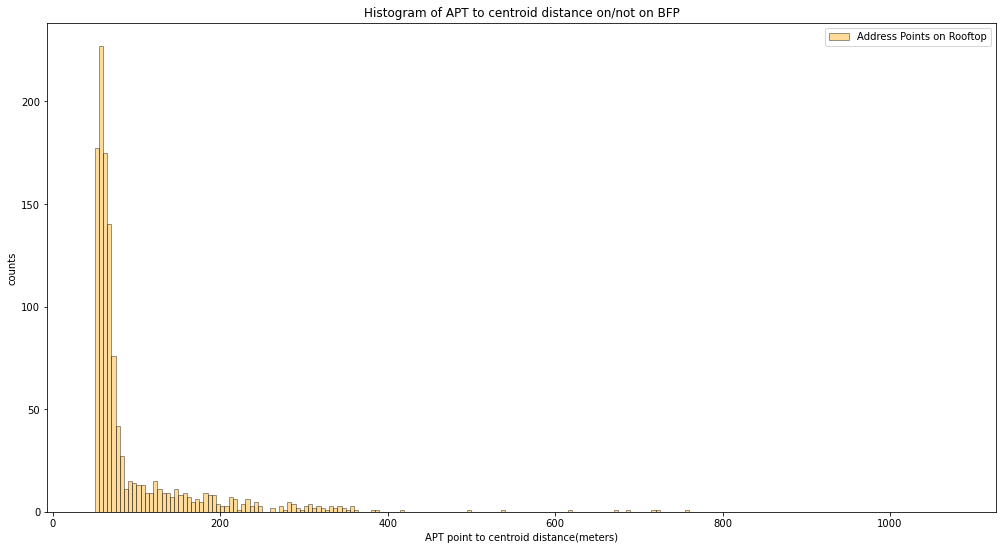

5453

In [10]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_co['APT_to_Centroid_distance'].loc[processed_df_co['APT_to_Centroid_distance']>50].values, bins = np.arange(45,max_dist,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

In [16]:
output_path = os.path.join(data_path,state,city,'Apt_realignment')
if not os.path.isdir:
    os.makedirs(output_path)

geo_dataframe = gpd.GeoDataFrame(df_for_analysis_usa_co_arapahoe, geometry='updated_geometries', crs="EPSG:4326")
filename = os.path.join(output_path,'APT_realigned_usa_uco_araphoe.shp')
geo_dataframe.to_file(driver='ESRI Shapefile', filename=filename)

## Miamidade_Florida

In [10]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment/utils')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance
from utils.extract_mnr_data import ExtractMNRData as extract_mnr_data


data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "Florida"
city = "Miamidade"

apt_data_path = os.path.join(data_path,state,"APT_2022_06_009_nam_usa_ufl.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_12086/Parcels_12086.shp")
building_geojson = os.path.join(data_path,state,'Florida.geojson')

In [24]:
if not os.path.isfile(apt_data_path):
    mnr_database = extract_mnr_data(country_code='_2022_06_009_nam_usa_ufl')
    mnr_database.connect_to_server()
    # out_path = os.path.join(data_path,state)
    # mnr_apt_df = mnr_database.extract_apt_addresses_data()
    # mnr_database.save_dataframe_as_shpfile(mnr_apt_df, out_path, filename='APT_2022_06_009_nam_usa_ufl.shp')

In [ ]:
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,building_shapefile=building_geojson,apt_shape_file=apt_data_path)
processed_df_miamidade = apt_preprocess.process_dataframe(bfp_count_per_parcel=1)
processed_df_miamidade.head(5)

In [3]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

processed_df_miamidade['APT_to_Centroid_distance'] = processed_df_miamidade.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)

processed_df_miamidade['APT_lat'] = processed_df_miamidade['APT'].apply(lambda z: z.y)
processed_df_miamidade['APT_long'] = processed_df_miamidade['APT'].apply(lambda z: z.x)

processed_df_miamidade['updated_lat'] = processed_df_miamidade['updated_geometries'].apply(lambda z: z.y)
processed_df_miamidade['updated_lon'] = processed_df_miamidade['updated_geometries'].apply(lambda z: z.x)

processed_df_miamidade.head()

,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,suffix,predir,postdir,sn_body,APT,APT_to_Centroid_distance,APT_lat,APT_long,updated_lat,updated_lon
0,3411320142000,12086,100660192_206370610,"POLYGON ((-80.26621 25.97010, -80.26620 25.970...","POLYGON ((-80.26573 25.97029, -80.265967 25.97...","POLYGON ((-80.26610 25.97033, -80.26611 25.970...",POINT (-80.26611 25.97028),0000554635002800000000000078eb03,Latn,ENG,...,Ave,NW,None,39th,POINT (-80.26617400000001 25.9702614),6.8,25.970261,-80.266174,25.970280,-80.266109
1,3411320142060,12086,100660192_206370609,"POLYGON ((-80.26672 25.97005, -80.26685 25.970...","POLYGON ((-80.266722 25.97006, -80.266718 25.9...","POLYGON ((-80.26672 25.97006, -80.26672 25.970...",POINT (-80.26670 25.97014),0000554635002800000000000078eb01,Latn,ENG,...,Ave,NW,None,39th,POINT (-80.26674559999999 25.9701337),4.4,25.970134,-80.266746,25.970136,-80.266701
2,3411320142050,12086,100660192_206370608,"POLYGON ((-80.26664 25.97004, -80.26672 25.970...","POLYGON ((-80.266722 25.97006, -80.266718 25.9...","POLYGON ((-80.26671 25.97010, -80.26669 25.970...",POINT (-80.26666 25.97014),0000554635002800000000000078eb00,Latn,ENG,...,Ave,NW,None,39th,POINT (-80.2666577 25.9701395),0.4,25.970139,-80.266658,25.970141,-80.266662
3,3411320142040,12086,100660192_206370607,"POLYGON ((-80.26656 25.97003, -80.26664 25.970...","POLYGON ((-80.266722 25.97006, -80.266718 25.9...","POLYGON ((-80.26663 25.97009, -80.26661 25.970...",POINT (-80.26661 25.97013),0000554635002800000000000078eaff,Latn,ENG,...,Ave,NW,None,39th,POINT (-80.2665928 25.9701919),6.7,25.970192,-80.266593,25.970133,-80.266610
5,3411320141380,12086,100660192_206370605,"POLYGON ((-80.26739 25.96993, -80.26740 25.970...","POLYGON ((-80.26718 25.970002, -80.26718200000...","POLYGON ((-80.26738 25.97007, -80.26718 25.970...",POINT (-80.26728 25.97004),0000554635002800000000000057a884,Latn,ENG,...,Ct,NW,None,40th Circle,POINT (-80.267262 25.97001),3.4,25.970010,-80.267262,25.970037,-80.267279


In [4]:
distance_greater_than_50m = processed_df_miamidade.loc[processed_df_miamidade['APT_to_Centroid_distance']>50].shape[0]
max_dist = processed_df_miamidade['APT_to_Centroid_distance'].loc[processed_df_miamidade['APT_to_Centroid_distance']>50].max()
print("Max distance APT from Parcel to Building Centroid {:.2f} m".format(processed_df_miamidade['APT_to_Centroid_distance'].loc[processed_df_miamidade['APT_to_Centroid_distance']>50].max()))
print("Data points greater than 50m: {:.2f}% ".format(100*(distance_greater_than_50m/processed_df_miamidade.shape[0])))

Max distance APT from Parcel to Building Centroid 778.60 m
Data points greater than 50m: 1.27% 


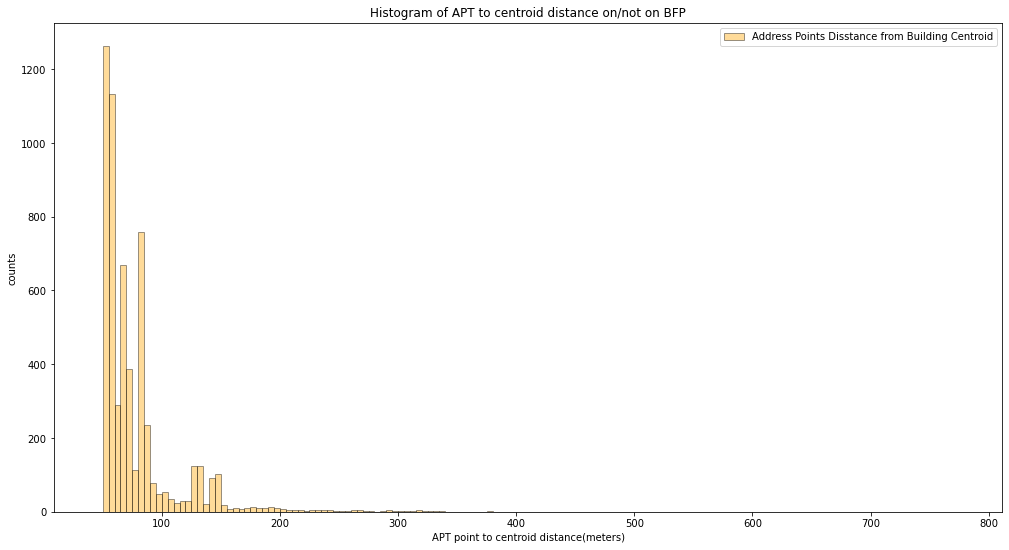

11678

In [6]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_miamidade['APT_to_Centroid_distance'].loc[processed_df_miamidade['APT_to_Centroid_distance']>=50].values, bins = np.arange(45,max_dist,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points Disstance from Building Centroid',color='orange')

plt.legend()
plt.show()
gc.collect()

In [7]:
df_for_analysis_usa_fl = processed_df_miamidade.drop(['APN','FIPS','PRCLDMPID','geometry','building_geometry','building_roi','APT'],axis=1)
df_for_analysis_usa_fl.head()

,updated_geometries,feat_id,iso_script,iso_lang_c,postal_cod,house_numb,state_prov,place_name,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT_to_Centroid_distance,APT_lat,APT_long,updated_lat,updated_lon
0,POINT (-80.26611 25.97028),0000554635002800000000000078eb03,Latn,ENG,33055,21369,FL,Opa Locka,NW 39th Ave,USA,None,Ave,NW,None,39th,6.8,25.970261,-80.266174,25.970280,-80.266109
1,POINT (-80.26670 25.97014),0000554635002800000000000078eb01,Latn,ENG,33055,21343,FL,Opa Locka,NW 39th Ave,USA,None,Ave,NW,None,39th,4.4,25.970134,-80.266746,25.970136,-80.266701
2,POINT (-80.26666 25.97014),0000554635002800000000000078eb00,Latn,ENG,33055,21341,FL,Opa Locka,NW 39th Ave,USA,None,Ave,NW,None,39th,0.4,25.970139,-80.266658,25.970141,-80.266662
3,POINT (-80.26661 25.97013),0000554635002800000000000078eaff,Latn,ENG,33055,21339,FL,Opa Locka,NW 39th Ave,USA,None,Ave,NW,None,39th,6.7,25.970192,-80.266593,25.970133,-80.266610
5,POINT (-80.26728 25.97004),0000554635002800000000000057a884,Latn,ENG,33055,21475,FL,Opa Locka,NW 40th Circle Ct,USA,None,Ct,NW,None,40th Circle,3.4,25.970010,-80.267262,25.970037,-80.267279


In [16]:
output_path = os.path.join(data_path,state,city,'Apt_realignment')
# print(output_path)
if not os.path.isdir:
    os.makedirs(output_path)
geo_dataframe = gpd.GeoDataFrame(df_for_analysis_usa_fl, geometry='updated_geometries', crs="EPSG:4326")
filename = os.path.join(output_path,'APT_realigned_usa_ufl_miamidade.shp')
geo_dataframe.to_file(driver='ESRI Shapefile', filename=filename)


## Duval_Florida

In [1]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/"
state = "Florida"
city = "Duval"
apt_data_path = os.path.join(data_path,state,"APT_2022_06_009_nam_usa_ufl.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_12031/Parcels_12031.shp")
building_geojson = os.path.join(data_path,state,'Florida.geojson')

/home/tandon/anaconda3/envs/pygeo/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,building_shapefile=building_geojson,apt_shape_file=apt_data_path)
processed_df_duval = apt_preprocess.process_dataframe(bfp_count_per_parcel=1)
processed_df_duval.head(10)

2022-08-03 09:52:37,236:INFO:- Creating Realignment-matrix for APT's
2022-08-03 09:52:37,236:INFO:- Processing Land Parcel data and Building Footprints 
2022-08-03 09:59:33,229:INFO:- Processing Anchor-Points data over Parcel-Building Geo-Dataframe


,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,state_prov,place_name,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT
1,0195520270R,12031,100660192_22021635,"POLYGON ((-81.74024 30.52834, -81.74049 30.528...","POLYGON ((-81.73952 30.528959, -81.739555 30.5...","POLYGON ((-81.73952 30.52896, -81.73955 30.529...",POINT (-81.73960 30.52901),00005546310028000000000000072912,Latn,ENG,...,FL,Jacksonville,Ressie Dr W,USA,None,Dr,None,W,Ressie,POINT (-81.73984900000001 30.528775)
3,0195870244R,12031,100660192_22021627,"POLYGON ((-81.74387 30.52774, -81.74422 30.528...","POLYGON ((-81.74365400000001 30.528007, -81.74...","POLYGON ((-81.74365 30.52801, -81.74354 30.528...",POINT (-81.74362 30.52812),0000554631002800000000000007290c,Latn,ENG,...,FL,Jacksonville,Puskita Trl,USA,None,Trl,None,None,Puskita,POINT (-81.743289 30.528184)
4,0195870230R,12031,100660192_22021626,"POLYGON ((-81.74422 30.52813, -81.74450 30.528...","POLYGON ((-81.743807 30.528454, -81.743832 30....","POLYGON ((-81.74381 30.52845, -81.74383 30.528...",POINT (-81.74390 30.52846),0000554631002800000000000007290d,Latn,ENG,...,FL,Jacksonville,Puskita Trl,USA,None,Trl,None,None,Puskita,POINT (-81.743526 30.528635)
5,0195520120R,12031,100660192_22021625,"POLYGON ((-81.73911 30.52914, -81.73947 30.529...","POLYGON ((-81.739011 30.529489, -81.739045 30....","POLYGON ((-81.73901 30.52949, -81.73905 30.529...",POINT (-81.73908 30.52952),00005546310028000000000000072936,Latn,ENG,...,FL,Jacksonville,Ressie Dr W,USA,None,Dr,None,W,Ressie,POINT (-81.738508 30.52961)
6,0195520250R,12031,100660192_22021640,"POLYGON ((-81.73965 30.52765, -81.74020 30.528...","POLYGON ((-81.739788 30.528179, -81.739749 30....","POLYGON ((-81.73979 30.52818, -81.73975 30.528...",POINT (-81.73971 30.52822),00005546310028000000000000072911,Latn,ENG,...,FL,Jacksonville,Ressie Dr W,USA,None,Dr,None,W,Ressie,POINT (-81.739389 30.528248)
9,0195870210R,12031,100660192_22021614,"POLYGON ((-81.74225 30.52863, -81.74227 30.528...","POLYGON ((-81.74181799999999 30.528895, -81.74...","POLYGON ((-81.74182 30.52889, -81.74172 30.528...",POINT (-81.74186 30.52900),0000554631002800000000000007290f,Latn,ENG,...,FL,Jacksonville,Puskita Trl,USA,None,Trl,None,None,Puskita,POINT (-81.741941 30.529352)
13,0195520280R,12031,100660192_22021636,"POLYGON ((-81.74057 30.52871, -81.74093 30.529...","POLYGON ((-81.74078799999999 30.528969, -81.74...","POLYGON ((-81.74079 30.52897, -81.74071 30.528...",POINT (-81.74073 30.52905),00005546310028000000000000072910,Latn,ENG,...,FL,Jacksonville,Ressie Dr W,USA,None,Dr,None,W,Ressie,POINT (-81.740183 30.529082)
16,0195990035R,12031,100660192_22023165,"POLYGON ((-81.64814 30.52886, -81.64922 30.529...","POLYGON ((-81.649278 30.529937, -81.649095 30....","POLYGON ((-81.64928 30.52994, -81.64910 30.529...",POINT (-81.64915 30.52993),fb34bd8fcf8d4027abac41ad3bf4239c,Latn,ENG,...,FL,Jacksonville,Williams Oak Dr,USA,None,Dr,None,None,Williams Oak,POINT (-81.64885700000001 30.529508)
18,1081140030R,12031,100660192_22023156,"POLYGON ((-81.64812 30.52716, -81.64812 30.527...","POLYGON ((-81.647007 30.529535, -81.6470049999...","POLYGON ((-81.64701 30.52953, -81.64700 30.529...",POINT (-81.64688 30.52948),00005546310028000000000001325dee,Latn,ENG,...,FL,Jacksonville,Butch Baine Dr E,USA,None,Dr,None,E,Butch Baine,POINT (-81.64767999999999 30.529939)
21,1061180005R,12031,100660192_22023152,"POLYGON ((-81.63158 30.54226, -81.63118 30.542...","POLYGON ((-81.627889 30.542662, -81.627804 30....","POLYGON ((-81.62789 30.54266, -81.62780 30.542...",POINT (-81.62781 30.54277),bd466a9b7e7447009b699aa544598767,Latn,ENG,...,FL,Jacksonville,Carter Trl,USA,None,Trl,None,None,Carter,POINT (-81.62992199999999 30.542732)


In [3]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

processed_df_duval['APT_to_Centroid_distance'] = processed_df_duval.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)

processed_df_duval['APT_lat'] = processed_df_duval['APT'].apply(lambda z: z.y)
processed_df_duval['APT_long'] = processed_df_duval['APT'].apply(lambda z: z.x)

processed_df_duval['updated_lat'] = processed_df_duval['updated_geometries'].apply(lambda z: z.y)
processed_df_duval['updated_long'] = processed_df_duval['updated_geometries'].apply(lambda z: z.x)

processed_df_duval.head()

,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,suffix,predir,postdir,sn_body,APT,APT_to_Centroid_distance,APT_lat,APT_long,updated_lat,updated_long
1,0195520270R,12031,100660192_22021635,"POLYGON ((-81.74024 30.52834, -81.74049 30.528...","POLYGON ((-81.73952 30.528959, -81.739555 30.5...","POLYGON ((-81.73952 30.52896, -81.73955 30.529...",POINT (-81.73960 30.52901),00005546310028000000000000072912,Latn,ENG,...,Dr,None,W,Ressie,POINT (-81.73984900000001 30.528775),35.3,30.528775,-81.739849,30.529010,-81.739601
3,0195870244R,12031,100660192_22021627,"POLYGON ((-81.74387 30.52774, -81.74422 30.528...","POLYGON ((-81.74365400000001 30.528007, -81.74...","POLYGON ((-81.74365 30.52801, -81.74354 30.528...",POINT (-81.74362 30.52812),0000554631002800000000000007290c,Latn,ENG,...,Trl,None,None,Puskita,POINT (-81.743289 30.528184),32.2,30.528184,-81.743289,30.528118,-81.743616
4,0195870230R,12031,100660192_22021626,"POLYGON ((-81.74422 30.52813, -81.74450 30.528...","POLYGON ((-81.743807 30.528454, -81.743832 30....","POLYGON ((-81.74381 30.52845, -81.74383 30.528...",POINT (-81.74390 30.52846),0000554631002800000000000007290d,Latn,ENG,...,Trl,None,None,Puskita,POINT (-81.743526 30.528635),40.7,30.528635,-81.743526,30.528461,-81.743900
5,0195520120R,12031,100660192_22021625,"POLYGON ((-81.73911 30.52914, -81.73947 30.529...","POLYGON ((-81.739011 30.529489, -81.739045 30....","POLYGON ((-81.73901 30.52949, -81.73905 30.529...",POINT (-81.73908 30.52952),00005546310028000000000000072936,Latn,ENG,...,Dr,None,W,Ressie,POINT (-81.738508 30.52961),55.8,30.529610,-81.738508,30.529523,-81.739082
6,0195520250R,12031,100660192_22021640,"POLYGON ((-81.73965 30.52765, -81.74020 30.528...","POLYGON ((-81.739788 30.528179, -81.739749 30....","POLYGON ((-81.73979 30.52818, -81.73975 30.528...",POINT (-81.73971 30.52822),00005546310028000000000000072911,Latn,ENG,...,Dr,None,W,Ressie,POINT (-81.739389 30.528248),30.6,30.528248,-81.739389,30.528216,-81.739707


In [14]:
distance_greater_than_50m = processed_df_duval.loc[processed_df_duval['APT_to_Centroid_distance']>50].shape[0]
max_dist = processed_df_duval['APT_to_Centroid_distance'].loc[processed_df_duval['APT_to_Centroid_distance']>50].max()
print("Max distance APT from Parcel to Building Centroid {:.2f} m".format(processed_df_duval['APT_to_Centroid_distance'].loc[processed_df_duval['APT_to_Centroid_distance']>50].max()))
print("Data points greater than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_duval.shape[0])))

Max distance APT from Parcel to Building Centroid 1243.10 m
Data points greater than 50m: 1.87%


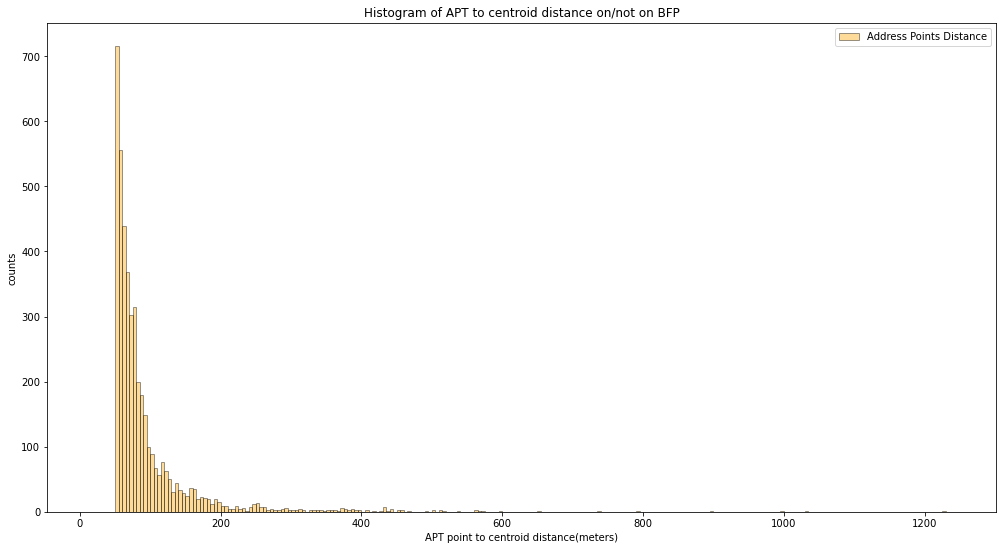

17424

In [16]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_duval['APT_to_Centroid_distance'].loc[processed_df_duval['APT_to_Centroid_distance']>=50].values, bins = np.arange(15,max_dist,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points Distance',color='orange')

plt.legend()
plt.show()
gc.collect()

In [17]:
df_for_analysis_usa_duval = processed_df_duval.drop(['APN','FIPS','PRCLDMPID','geometry','building_geometry','building_roi','APT'],axis=1)
df_for_analysis_usa_duval.head()

,updated_geometries,feat_id,iso_script,iso_lang_c,postal_cod,house_numb,state_prov,place_name,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT_to_Centroid_distance,APT_lat,APT_long,updated_lat,updated_long
1,POINT (-81.73960 30.52901),00005546310028000000000000072912,Latn,ENG,32218,16050,FL,Jacksonville,Ressie Dr W,USA,None,Dr,None,W,Ressie,35.3,30.528775,-81.739849,30.529010,-81.739601
3,POINT (-81.74362 30.52812),0000554631002800000000000007290c,Latn,ENG,32218,16066,FL,Jacksonville,Puskita Trl,USA,None,Trl,None,None,Puskita,32.2,30.528184,-81.743289,30.528118,-81.743616
4,POINT (-81.74390 30.52846),0000554631002800000000000007290d,Latn,ENG,32218,16070,FL,Jacksonville,Puskita Trl,USA,None,Trl,None,None,Puskita,40.7,30.528635,-81.743526,30.528461,-81.743900
5,POINT (-81.73908 30.52952),00005546310028000000000000072936,Latn,ENG,32218,16055,FL,Jacksonville,Ressie Dr W,USA,None,Dr,None,W,Ressie,55.8,30.529610,-81.738508,30.529523,-81.739082
6,POINT (-81.73971 30.52822),00005546310028000000000000072911,Latn,ENG,32218,16044,FL,Jacksonville,Ressie Dr W,USA,None,Dr,None,W,Ressie,30.6,30.528248,-81.739389,30.528216,-81.739707


In [18]:
output_path = os.path.join(data_path,state,city,'Apt_realignment') 
os.makedirs(output_path,exist_ok=True)

geo_dataframe = gpd.GeoDataFrame(df_for_analysis_usa_duval, geometry='updated_geometries', crs="EPSG:4326")
filename = os.path.join(output_path,'APT_realigned_2022_06_009_nam_usa_ufl_duval.shp')
geo_dataframe.to_file(driver='ESRI Shapefile', filename=filename)


## Harris Georgia

In [2]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "Georgia"
city = "Harris"
apt_data_path = os.path.join(data_path,state,"APT_2022_06_009_nam_usa_ugx.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_13145/Parcels_13145.shp")
building_geojson = os.path.join(data_path,state,'Georgia.geojson')

In [3]:
if not os.path.isfile(apt_data_path):
    print("downloading .. ")
    mnr_database = extract_mnr_data(country_code='_2022_06_009_nam_usa_ugx')
    mnr_database.connect_to_server()

    out_path = os.path.join(data_path,state)
    # mnr_apt_df = mnr_database.extract_apt_addresses_data()
    # mnr_database.save_dataframe_as_shpfile(mnr_apt_df, out_path, filename='APT_2022_06_009_nam_usa_ugx.shp')

In [4]:
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,building_shapefile=building_geojson,apt_shape_file=apt_data_path)
processed_df_harris = apt_preprocess.process_dataframe(bfp_count_per_parcel=1)
processed_df_harris.head(10)

2022-08-02 14:26:10,741:INFO:- Creating Realignment-matrix for APT's
2022-08-02 14:26:10,743:INFO:- Processing Land Parcel data and Building Footprints 
2022-08-02 14:29:46,331:INFO:- Processing Anchor-Points data over Parcel-Building Geo-Dataframe


,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,state_prov,place_name,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT
1,055 035,13145,100660192_29526623,"POLYGON ((-84.88826 32.85316, -84.88836 32.853...","POLYGON ((-84.887742 32.8534, -84.887594000000...","POLYGON ((-84.88774 32.85340, -84.88759 32.853...",POINT (-84.88767 32.85348),000055473200280000000000003643be,Latn,ENG,...,GA,Pine Mountain,Bethany Church Rd,USA,None,Rd,None,None,Bethany Church,POINT (-84.8875065 32.8536535)
38,021 052,13145,100660192_29528021,"POLYGON ((-85.06332 32.83041, -85.06479 32.833...","POLYGON ((-85.06339800000001 32.831865, -85.06...","POLYGON ((-85.06340 32.83187, -85.06320 32.831...",POINT (-85.06330 32.83191),000055473200280000000000003641f3,Latn,ENG,...,GA,West Point,W Mars Hill Dr,USA,None,Dr,W,None,Mars Hill,POINT (-85.06347 32.8318995)
40,021 046,13145,100660192_29528015,"POLYGON ((-85.06725 32.83011, -85.06795 32.830...","POLYGON ((-85.067859 32.832819, -85.067948 32....","POLYGON ((-85.06786 32.83282, -85.06795 32.832...",POINT (-85.06796 32.83276),000055473200280000000000003641ed,Latn,ENG,...,GA,West Point,W Mars Hill Dr,USA,None,Dr,W,None,Mars Hill,POINT (-85.06799719999999 32.8318358)
43,021 072,13145,100660192_29528012,"POLYGON ((-85.06160 32.83330, -85.06168 32.834...","POLYGON ((-85.061013 32.833844, -85.061019 32....","POLYGON ((-85.06101 32.83384, -85.06102 32.833...",POINT (-85.06113 32.83393),0000554732002800000000000038ae3b,Latn,ENG,...,GA,West Point,Monument Rd,USA,None,Rd,None,None,Monument,POINT (-85.0608984 32.8339975)
46,022 008A,13145,100660192_29528003,"POLYGON ((-85.05619 32.84175, -85.05720 32.843...","POLYGON ((-85.05600800000001 32.842261, -85.05...","POLYGON ((-85.05601 32.84226, -85.05599 32.842...",POINT (-85.05590 32.84226),000055473200280000000000003642be,Latn,ENG,...,GA,West Point,O'Neal Rd,USA,None,Rd,None,None,O'Neal,POINT (-85.0563219 32.8426026)
50,015A018,13145,100660192_29536998,"POLYGON ((-85.06565 32.61307, -85.06657 32.613...","POLYGON ((-85.065899 32.613392, -85.065888 32....","POLYGON ((-85.06590 32.61339, -85.06589 32.613...",POINT (-85.06590 32.61342),00005547320028000000000000361a36,Latn,ENG,...,GA,Fortson,River Ridge Ct,USA,None,Ct,None,None,River Ridge,POINT (-85.0661252 32.6133939)
52,015A012,13145,100660192_29537000,"POLYGON ((-85.06466 32.61223, -85.06541 32.612...","POLYGON ((-85.06506299999999 32.613071, -85.06...","POLYGON ((-85.06506 32.61307, -85.06505 32.612...",POINT (-85.06500 32.61301),00005547320028000000000000361a26,Latn,ENG,...,GA,Fortson,River Ridge Ct,USA,None,Ct,None,None,River Ridge,POINT (-85.0649251 32.6129264)
55,015 153,13145,100660192_29536995,"POLYGON ((-85.06201 32.61325, -85.06301 32.614...","POLYGON ((-85.061854 32.613797, -85.061829 32....","POLYGON ((-85.06185 32.61380, -85.06183 32.613...",POINT (-85.06179 32.61372),00005547320028000000000000361a4b,Latn,ENG,...,GA,Fortson,Goat Rock Rd,USA,None,Rd,None,None,Goat Rock,POINT (-85.06209250000001 32.6140368)
60,015A002,13145,100660192_29536990,"POLYGON ((-85.06351 32.61490, -85.06398 32.615...","POLYGON ((-85.063215 32.6155, -85.063129 32.61...","POLYGON ((-85.06321 32.61550, -85.06313 32.615...",POINT (-85.06327 32.61554),00005547320028000000000000361a97,Latn,ENG,...,GA,Fortson,Skyline Dr,USA,None,Dr,None,None,Skyline,POINT (-85.0634538 32.6153467)
62,015A001,13145,100660192_29536988,"POLYGON ((-85.06398 32.61556, -85.06397 32.616...","POLYGON ((-85.06405599999999 32.615605, -85.06...","POLYGON ((-85.06406 32.61561, -85.06395 32.615...",POINT (-85.06401 32.61566),00005547320028000000000000361ab4,Latn,ENG,...,GA,Fortson,Adcock Dr,USA,None,Dr,None,None,Adcock,POINT (-85.0635415 32.615907)


In [11]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

processed_df_harris['APT_to_Centroid_distance'] = processed_df_harris.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)

processed_df_harris['APT_lat'] = processed_df_harris['APT'].apply(lambda z: z.y)
processed_df_harris['APT_lon'] = processed_df_harris['APT'].apply(lambda z: z.x)

processed_df_harris['updated_lat'] = processed_df_harris['updated_geometries'].apply(lambda z: z.y)
processed_df_harris['updated_lon'] = processed_df_harris['updated_geometries'].apply(lambda z: z.x)

processed_df_harris.head()

,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,suffix,predir,postdir,sn_body,APT,APT_to_Centroid_distance,APT_lat,APT_lon,updated_lat,updated_lon
1,055 035,13145,100660192_29526623,"POLYGON ((-84.88826 32.85316, -84.88836 32.853...","POLYGON ((-84.887742 32.8534, -84.887594000000...","POLYGON ((-84.88774 32.85340, -84.88759 32.853...",POINT (-84.88767 32.85348),000055473200280000000000003643be,Latn,ENG,...,Rd,None,None,Bethany Church,POINT (-84.8875065 32.8536535),24.8,32.853654,-84.887507,32.853476,-84.887668
38,021 052,13145,100660192_29528021,"POLYGON ((-85.06332 32.83041, -85.06479 32.833...","POLYGON ((-85.06339800000001 32.831865, -85.06...","POLYGON ((-85.06340 32.83187, -85.06320 32.831...",POINT (-85.06330 32.83191),000055473200280000000000003641f3,Latn,ENG,...,Dr,W,None,Mars Hill,POINT (-85.06347 32.8318995),15.6,32.831899,-85.063470,32.831912,-85.063304
40,021 046,13145,100660192_29528015,"POLYGON ((-85.06725 32.83011, -85.06795 32.830...","POLYGON ((-85.067859 32.832819, -85.067948 32....","POLYGON ((-85.06786 32.83282, -85.06795 32.832...",POINT (-85.06796 32.83276),000055473200280000000000003641ed,Latn,ENG,...,Dr,W,None,Mars Hill,POINT (-85.06799719999999 32.8318358),102.8,32.831836,-85.067997,32.832760,-85.067955
43,021 072,13145,100660192_29528012,"POLYGON ((-85.06160 32.83330, -85.06168 32.834...","POLYGON ((-85.061013 32.833844, -85.061019 32....","POLYGON ((-85.06101 32.83384, -85.06102 32.833...",POINT (-85.06113 32.83393),0000554732002800000000000038ae3b,Latn,ENG,...,Rd,None,None,Monument,POINT (-85.0608984 32.8339975),23.3,32.833998,-85.060898,32.833925,-85.061133
46,022 008A,13145,100660192_29528003,"POLYGON ((-85.05619 32.84175, -85.05720 32.843...","POLYGON ((-85.05600800000001 32.842261, -85.05...","POLYGON ((-85.05601 32.84226, -85.05599 32.842...",POINT (-85.05590 32.84226),000055473200280000000000003642be,Latn,ENG,...,Rd,None,None,O'Neal,POINT (-85.0563219 32.8426026),54.8,32.842603,-85.056322,32.842259,-85.055902


In [12]:
distance_greater_than_50m = processed_df_harris.loc[processed_df_harris['APT_to_Centroid_distance']>50].shape[0]
print("Data points greater than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_harris.shape[0])))

Data points greater than 50m: 16.98%


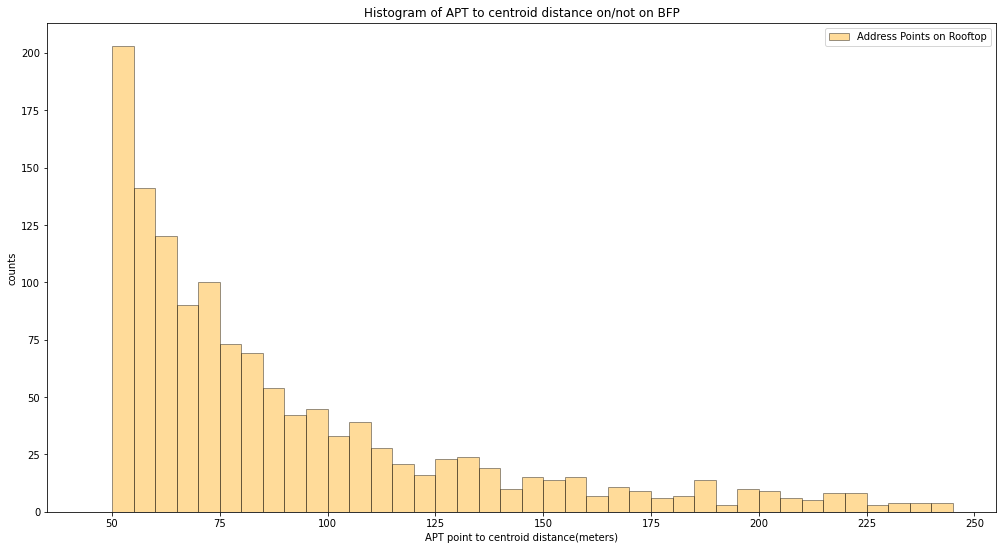

5767

In [13]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_harris['APT_to_Centroid_distance'].loc[processed_df_harris['APT_to_Centroid_distance']>50].values, bins = np.arange(45,250,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

In [18]:
print(processed_df_harris.shape)
processed_df_harris[['updated_geometries','feat_id','postal_cod','house_numb','state_prov','place_name','street_nam','country_co','prefix','suffix',
	                'predir','postdir','sn_body','APT_to_Centroid_distance','APT_lat','APT_lon','updated_lat',	'updated_lon']].head()

(8699, 27)


,updated_geometries,feat_id,postal_cod,house_numb,state_prov,place_name,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT_to_Centroid_distance,APT_lat,APT_lon,updated_lat,updated_lon
1,POINT (-84.88767 32.85348),000055473200280000000000003643be,31822,1170,GA,Pine Mountain,Bethany Church Rd,USA,None,Rd,None,None,Bethany Church,24.8,32.853654,-84.887507,32.853476,-84.887668
38,POINT (-85.06330 32.83191),000055473200280000000000003641f3,31833,140,GA,West Point,W Mars Hill Dr,USA,None,Dr,W,None,Mars Hill,15.6,32.831899,-85.063470,32.831912,-85.063304
40,POINT (-85.06796 32.83276),000055473200280000000000003641ed,31833,450,GA,West Point,W Mars Hill Dr,USA,None,Dr,W,None,Mars Hill,102.8,32.831836,-85.067997,32.832760,-85.067955
43,POINT (-85.06113 32.83393),0000554732002800000000000038ae3b,31833,1701,GA,West Point,Monument Rd,USA,None,Rd,None,None,Monument,23.3,32.833998,-85.060898,32.833925,-85.061133
46,POINT (-85.05590 32.84226),000055473200280000000000003642be,31833,351,GA,West Point,O'Neal Rd,USA,None,Rd,None,None,O'Neal,54.8,32.842603,-85.056322,32.842259,-85.055902


In [19]:
output_path = os.path.join(data_path,state,city,'Apt_realignment') 
os.makedirs(output_path,exist_ok=True)

df_for_analysis_usa_harris = processed_df_harris.drop(['APN','FIPS','PRCLDMPID','geometry','building_geometry','building_roi','APT'],axis=1)

geo_dataframe = gpd.GeoDataFrame(df_for_analysis_usa_harris, geometry='updated_geometries', crs="EPSG:4326")
filename = os.path.join(output_path,'APT_realigned_nam_usa_ugx_Harris.shp')
geo_dataframe.to_file(driver='ESRI Shapefile', filename=filename)
